# Exercise 9 - CIFAR10 Challenge

## Group ID: 21
- Andrea Tufo
- Hongli Lin
- Michele Paterson
## Exercise day: Tuesday

## Task description:
In this exercise, you have all the freedom to come up with the best model, data augmentation, hyperparameters, loss function, etc. - essentially everything you have learned so far in the course - to achieve the highest possible accuracy on the CIFAR10 dataset.
You are allowed to use PyTorch functions for mechanisms which were covered in the previous exercises or lectures. But you are not allowed to use pre-trained models or any external dataset for training.
Also you have to provide a brief explanation of your model and all the decisions (hyperparameters, augmentation, etc.) you made to achieve the claimed accuracy.
To make the task more challenging, you have to train on an imbalanced traindataset.

Hint: For the final training process, you can use Google Colab which provides (time-restricted) free GPU resources.

## Submission:
- You have to submit a single .zip file containing this notebook and the weights of your model (model.pth).
- The total size of the .zip file must be less than 256MB. (absolute maximum, less is always better)
- The model file should be named model.pth.
- The test code at the end of your submitted notebook must run by only loading the provided model.pth file. We will not be able to run any training code.
- Upload the .zip via Ilias by clicking the **left** button called **"Datei hochladen"**(if you use the German version of Ilias). Please not use the right one, because Ilias will unzip your file in that case and can't handle .pth files.<br>
![](./upload.png)

## Evaluation:
The evaluation of the exercise is based on the achieved accuracy on the test dataset.
The baseline is 65% accuracy on the test dataset.

Note: The three best submissions will be awarded in the lecture with a small prize.

## Brief explanation of the model and the techniques used:
### Model Description 
We replicated the ResNext29 model for CIFAR-10:
https://arxiv.org/abs/1611.05431v2
- In short, the architecture utilizes more channels, but the channels are divided
into groups which don't share parameters between them. The number of groups
are called cardinarity and considered another hyperparameter important for 
fine-tuning.

According to this article, it performs better on CIFAR-10 comparing
to other CNN methods:
https://ieeexplore.ieee.org/abstract/document/10604269?casa_token=wK3e1i1MnKcAAAAA:9Uji_Pn9RWXctmx7_GeF8DnukBbJKLuNjPGppS4qY8b8s2IHzINBAR2WUg1JDKLVtZDLO5fXsA

### Other Decisions you made
- Augmentations: To deal with imbalanced data, we use a random choice of
CutMix and Mix up. Some other regular augmentation techniques are also applied.
As tested, Random Erasing does not help and may decrease the final accuracy.

- Batch Size: 128
- Number of Epochs: 120 but converges at around 100
- Learning rate: start at 0.001. After 30 and 60 epochs, decrease learning rate
by 1/10 to further finetune the model. The numbers are from experiences.


## Code:


### Imports and data loading

In [157]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified


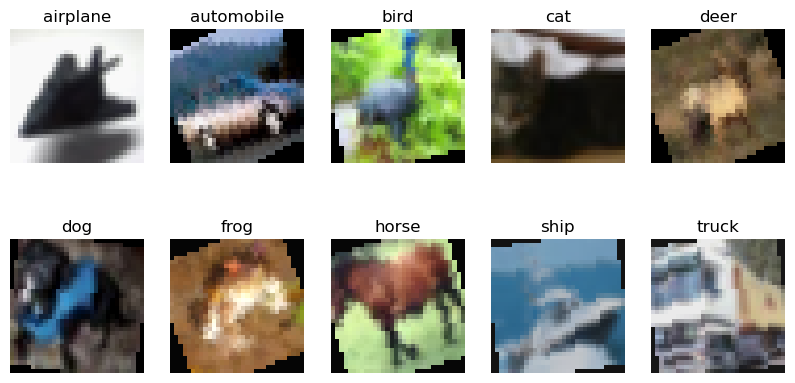

In [158]:
from torchvision.transforms import v2 as T

num_classes = 10
# deal with imbalanced dataset
cutmix = T.CutMix(num_classes=num_classes)
mixup = T.MixUp(num_classes=num_classes)
cutmix_or_mixup = T.RandomChoice([cutmix, mixup])

mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(list(mean), list(std))])
color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2)
transform_train = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(size=32, scale=(0.8,1)),
        T.RandomRotation(degrees=30),
        T.RandomApply([color_jitter], p=0.8),
        T.Normalize(list(mean), list(std))])

batch_size = 128

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()


### Model

Residual Blocks:

(i)if producing spatial maps of the same size, the blocks share
the same hyper-parameters (width and filter sizes), and 

(ii)
each time when the spatial map is downsampled by a factor of 2, the width of the blocks is multiplied by a factor
of 2.

ResNext performs well on CIFAR
https://arxiv.org/pdf/1611.05431v2

In [159]:
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, hiddenchannel, outchannel, stride=1, group = 1):
        super(ResidualBlock, self).__init__()
        # left: (in_size - 3 + 2)/s + 1 = (in_size -1)/s + 1 = out_size
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, hiddenchannel, kernel_size=1, stride=1, padding=0, bias=False, groups=group),
            nn.BatchNorm2d(hiddenchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(hiddenchannel, hiddenchannel, kernel_size=3, stride=stride, padding=1, bias=False, groups=group),
            nn.BatchNorm2d(hiddenchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(hiddenchannel, outchannel, kernel_size=1, stride=1, padding=0, bias=False, groups=group),
            nn.BatchNorm2d(outchannel),
        )
        # shortcut: (in_size - 1)/s + 1 = out_size
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                # zero padding to make the dimensions match
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out

class ResNeXt29(nn.Module):
    def __init__(self, c_in=1, num_classes=10, cardinality=8):
        super(ResNeXt29, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            ResidualBlock(64, 128, 256, stride=3, group=cardinality),
            ResidualBlock(256, 128, 256, stride=3, group=cardinality),
            ResidualBlock(256, 128, 256, stride=3, group=cardinality),
        )
        self.conv3 = nn.Sequential(
            ResidualBlock(256, 256, 512, stride=3, group=cardinality),
            ResidualBlock(512, 256, 512, stride=3, group=cardinality),
            ResidualBlock(512, 256, 512, stride=3, group=cardinality),
        )
        self.conv4 = nn.Sequential(
            ResidualBlock(512, 512, 1024, stride=3, group=cardinality),
            ResidualBlock(1024, 512, 1024, stride=3, group=cardinality),
            ResidualBlock(1024, 512, 1024, stride=3, group=cardinality),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = F.avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Optimizer, Validation and Training

In [160]:
class Optimizer:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [161]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [154]:
def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_before = validate(model, testloader, device)
    print(f"Accuracy before training: {acc_before}")
    for epoch in range(num_epochs):
        # change learning rate after 150 and 225 epochs
        if epoch == 30:
            optimizer.lr /= 10
        if epoch == 60:
            optimizer.lr /= 10
        if epoch == 90:
            optimizer.lr /= 10
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # deal with imbalanced dataset
            inputs, labels = cutmix_or_mixup(inputs, labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [155]:
model = ResNeXt29(c_in = 3, num_classes = 10, cardinality = 32)
criterion = nn.CrossEntropyLoss()
# optimizer = Optimizer(model.parameters(), lr=0.01)
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device {device}")

Using device cuda


In [96]:
train(model, trainloader, testloader, criterion, optimizer, num_epochs=150, device=device)

Accuracy before training: 0.6004


100%|██████████| 215/215 [00:20<00:00, 10.71it/s]


Epoch 1, loss: 1.438592449731605
Accuracy on train set: 0.724909090909091
Accuracy on test set: 0.6061


100%|██████████| 215/215 [00:19<00:00, 10.80it/s]


Epoch 2, loss: 1.42408717482589
Accuracy on train set: 0.7290545454545454
Accuracy on test set: 0.624


100%|██████████| 215/215 [00:19<00:00, 10.76it/s]


Epoch 3, loss: 1.4301963797835417
Accuracy on train set: 0.7347272727272727
Accuracy on test set: 0.6225


100%|██████████| 215/215 [00:20<00:00, 10.72it/s]


Epoch 4, loss: 1.4090135435725368
Accuracy on train set: 0.7365090909090909
Accuracy on test set: 0.6253


100%|██████████| 215/215 [00:20<00:00, 10.56it/s]


Epoch 5, loss: 1.4450035732845927
Accuracy on train set: 0.7413090909090909
Accuracy on test set: 0.6341


100%|██████████| 215/215 [00:20<00:00, 10.60it/s]


Epoch 6, loss: 1.3930476854013842
Accuracy on train set: 0.7422545454545455
Accuracy on test set: 0.6292


100%|██████████| 215/215 [00:19<00:00, 10.86it/s]


Epoch 7, loss: 1.4293870493423106
Accuracy on train set: 0.7438545454545454
Accuracy on test set: 0.6375


100%|██████████| 215/215 [00:19<00:00, 10.88it/s]


Epoch 8, loss: 1.4181327636851822
Accuracy on train set: 0.748
Accuracy on test set: 0.6427


100%|██████████| 215/215 [00:20<00:00, 10.75it/s]


Epoch 9, loss: 1.4380490882452144
Accuracy on train set: 0.744
Accuracy on test set: 0.6372


100%|██████████| 215/215 [00:21<00:00, 10.09it/s]


Epoch 10, loss: 1.4308070363000382
Accuracy on train set: 0.747890909090909
Accuracy on test set: 0.638


100%|██████████| 215/215 [00:21<00:00, 10.19it/s]


Epoch 11, loss: 1.4046439570049907
Accuracy on train set: 0.7502545454545455
Accuracy on test set: 0.6418


100%|██████████| 215/215 [00:20<00:00, 10.45it/s]


Epoch 12, loss: 1.3905261691226516
Accuracy on train set: 0.7449090909090909
Accuracy on test set: 0.6409


100%|██████████| 215/215 [00:20<00:00, 10.41it/s]


Epoch 13, loss: 1.3910692045854969
Accuracy on train set: 0.7490545454545454
Accuracy on test set: 0.6347


100%|██████████| 215/215 [00:20<00:00, 10.37it/s]


Epoch 14, loss: 1.3980831767237463
Accuracy on train set: 0.7509454545454546
Accuracy on test set: 0.6429


100%|██████████| 215/215 [00:19<00:00, 10.76it/s]


Epoch 15, loss: 1.4221864004467808
Accuracy on train set: 0.7478545454545454
Accuracy on test set: 0.6429


100%|██████████| 215/215 [00:20<00:00, 10.47it/s]


Epoch 16, loss: 1.3939656313075575
Accuracy on train set: 0.7500363636363636
Accuracy on test set: 0.6446


100%|██████████| 215/215 [00:19<00:00, 10.79it/s]


Epoch 17, loss: 1.427870792289113
Accuracy on train set: 0.7533454545454545
Accuracy on test set: 0.657


100%|██████████| 215/215 [00:19<00:00, 10.84it/s]


Epoch 18, loss: 1.4088554950647576
Accuracy on train set: 0.7520363636363636
Accuracy on test set: 0.6536


100%|██████████| 215/215 [00:20<00:00, 10.63it/s]


Epoch 19, loss: 1.403991855576981
Accuracy on train set: 0.7557818181818182
Accuracy on test set: 0.6597


100%|██████████| 215/215 [00:20<00:00, 10.67it/s]


Epoch 20, loss: 1.438736659149791
Accuracy on train set: 0.7505454545454545
Accuracy on test set: 0.6501


100%|██████████| 215/215 [00:19<00:00, 10.76it/s]


Epoch 21, loss: 1.3965158845103065
Accuracy on train set: 0.7549090909090909
Accuracy on test set: 0.6497


100%|██████████| 215/215 [00:19<00:00, 10.79it/s]


Epoch 22, loss: 1.4263112201247103
Accuracy on train set: 0.7528
Accuracy on test set: 0.6508


100%|██████████| 215/215 [00:20<00:00, 10.57it/s]


Epoch 23, loss: 1.3940075375312984
Accuracy on train set: 0.7532363636363636
Accuracy on test set: 0.6539


100%|██████████| 215/215 [00:20<00:00, 10.65it/s]


Epoch 24, loss: 1.4117961883544923
Accuracy on train set: 0.7554909090909091
Accuracy on test set: 0.6539


100%|██████████| 215/215 [00:19<00:00, 10.82it/s]


Epoch 25, loss: 1.4021264999411827
Accuracy on train set: 0.7578545454545454
Accuracy on test set: 0.6473


100%|██████████| 215/215 [00:19<00:00, 10.80it/s]


Epoch 26, loss: 1.4032132825186086
Accuracy on train set: 0.7557818181818182
Accuracy on test set: 0.6432


100%|██████████| 215/215 [00:20<00:00, 10.63it/s]


Epoch 27, loss: 1.3817874589631725
Accuracy on train set: 0.7622909090909091
Accuracy on test set: 0.6589


100%|██████████| 215/215 [00:19<00:00, 10.81it/s]


Epoch 28, loss: 1.4061056910559189
Accuracy on train set: 0.7568363636363636
Accuracy on test set: 0.6511


100%|██████████| 215/215 [00:20<00:00, 10.72it/s]


Epoch 29, loss: 1.3472391491712525
Accuracy on train set: 0.7581454545454546
Accuracy on test set: 0.6517


100%|██████████| 215/215 [00:20<00:00, 10.47it/s]


Epoch 30, loss: 1.3931382705998976
Accuracy on train set: 0.7644727272727273
Accuracy on test set: 0.6533


100%|██████████| 215/215 [00:20<00:00, 10.63it/s]


Epoch 31, loss: 1.4163578205330427
Accuracy on train set: 0.7629090909090909
Accuracy on test set: 0.657


100%|██████████| 215/215 [00:21<00:00, 10.21it/s]


Epoch 32, loss: 1.410597273915313
Accuracy on train set: 0.7641454545454546
Accuracy on test set: 0.6521


100%|██████████| 215/215 [00:20<00:00, 10.72it/s]


Epoch 33, loss: 1.4373584475628165
Accuracy on train set: 0.7597090909090909
Accuracy on test set: 0.6425


100%|██████████| 215/215 [00:20<00:00, 10.68it/s]


Epoch 34, loss: 1.3607406860174134
Accuracy on train set: 0.7642181818181818
Accuracy on test set: 0.658


100%|██████████| 215/215 [00:20<00:00, 10.73it/s]


Epoch 35, loss: 1.3736311640850334
Accuracy on train set: 0.7596727272727273
Accuracy on test set: 0.6492


100%|██████████| 215/215 [00:20<00:00, 10.43it/s]


Epoch 36, loss: 1.3517110927160396
Accuracy on train set: 0.766109090909091
Accuracy on test set: 0.6607


100%|██████████| 215/215 [00:20<00:00, 10.50it/s]


Epoch 37, loss: 1.3741478027299394
Accuracy on train set: 0.7602545454545454
Accuracy on test set: 0.6704


100%|██████████| 215/215 [00:20<00:00, 10.48it/s]


Epoch 38, loss: 1.3764049233392228
Accuracy on train set: 0.7698909090909091
Accuracy on test set: 0.6537


100%|██████████| 215/215 [00:21<00:00,  9.90it/s]


Epoch 39, loss: 1.371203519299973
Accuracy on train set: 0.7676
Accuracy on test set: 0.6641


100%|██████████| 215/215 [00:20<00:00, 10.57it/s]


Epoch 40, loss: 1.3840594901595005
Accuracy on train set: 0.7666545454545455
Accuracy on test set: 0.6546


100%|██████████| 215/215 [00:20<00:00, 10.60it/s]


Epoch 41, loss: 1.410648600999699
Accuracy on train set: 0.7669818181818182
Accuracy on test set: 0.6575


100%|██████████| 215/215 [00:20<00:00, 10.50it/s]


Epoch 42, loss: 1.3742472826048384
Accuracy on train set: 0.7696363636363637
Accuracy on test set: 0.6574


100%|██████████| 215/215 [00:20<00:00, 10.46it/s]


Epoch 43, loss: 1.393368976892427
Accuracy on train set: 0.7636
Accuracy on test set: 0.6501


100%|██████████| 215/215 [00:20<00:00, 10.41it/s]


Epoch 44, loss: 1.3507547070813732
Accuracy on train set: 0.7681454545454546
Accuracy on test set: 0.6593


100%|██████████| 215/215 [00:20<00:00, 10.38it/s]


Epoch 45, loss: 1.3737723758054334
Accuracy on train set: 0.766
Accuracy on test set: 0.6616


100%|██████████| 215/215 [00:20<00:00, 10.54it/s]


Epoch 46, loss: 1.3712970833445703
Accuracy on train set: 0.7717454545454545
Accuracy on test set: 0.6482


100%|██████████| 215/215 [00:20<00:00, 10.52it/s]


Epoch 47, loss: 1.386229790920435
Accuracy on train set: 0.7708
Accuracy on test set: 0.6672


100%|██████████| 215/215 [00:19<00:00, 10.87it/s]


Epoch 48, loss: 1.362976045109505
Accuracy on train set: 0.7713454545454546
Accuracy on test set: 0.6727


100%|██████████| 215/215 [00:19<00:00, 10.93it/s]


Epoch 49, loss: 1.3773206555566122
Accuracy on train set: 0.7706181818181819
Accuracy on test set: 0.6703


100%|██████████| 215/215 [00:19<00:00, 10.84it/s]


Epoch 50, loss: 1.3588613365971765
Accuracy on train set: 0.7739272727272727
Accuracy on test set: 0.6664


100%|██████████| 215/215 [00:20<00:00, 10.56it/s]


Epoch 51, loss: 1.3364557670992474
Accuracy on train set: 0.7734545454545455
Accuracy on test set: 0.6692


100%|██████████| 215/215 [00:19<00:00, 10.79it/s]


Epoch 52, loss: 1.3777889969737032
Accuracy on train set: 0.7744363636363636
Accuracy on test set: 0.6607


100%|██████████| 215/215 [00:19<00:00, 10.78it/s]


Epoch 53, loss: 1.4011512906052346
Accuracy on train set: 0.7726909090909091
Accuracy on test set: 0.658


100%|██████████| 215/215 [00:19<00:00, 10.85it/s]


Epoch 54, loss: 1.3891617070796878
Accuracy on train set: 0.7721818181818182
Accuracy on test set: 0.6622


100%|██████████| 215/215 [00:19<00:00, 10.85it/s]


Epoch 55, loss: 1.3728829220283862
Accuracy on train set: 0.7732
Accuracy on test set: 0.6705


100%|██████████| 215/215 [00:20<00:00, 10.60it/s]


Epoch 56, loss: 1.4062005214912947
Accuracy on train set: 0.7747272727272727
Accuracy on test set: 0.6683


100%|██████████| 215/215 [00:20<00:00, 10.65it/s]


Epoch 57, loss: 1.3453062209972115
Accuracy on train set: 0.7753454545454546
Accuracy on test set: 0.6616


100%|██████████| 215/215 [00:19<00:00, 10.75it/s]


Epoch 58, loss: 1.393081038497215
Accuracy on train set: 0.7761818181818182
Accuracy on test set: 0.6613


100%|██████████| 215/215 [00:20<00:00, 10.60it/s]


Epoch 59, loss: 1.3739130228064782
Accuracy on train set: 0.7761090909090909
Accuracy on test set: 0.669


100%|██████████| 215/215 [00:19<00:00, 10.82it/s]


Epoch 60, loss: 1.3707055316414944
Accuracy on train set: 0.7770545454545454
Accuracy on test set: 0.6534


100%|██████████| 215/215 [00:20<00:00, 10.52it/s]


Epoch 61, loss: 1.3646480332973392
Accuracy on train set: 0.7778181818181819
Accuracy on test set: 0.6716


100%|██████████| 215/215 [00:20<00:00, 10.75it/s]


Epoch 62, loss: 1.3643294051636097
Accuracy on train set: 0.7803272727272728
Accuracy on test set: 0.6778


100%|██████████| 215/215 [00:20<00:00, 10.55it/s]


Epoch 63, loss: 1.3875797332719315
Accuracy on train set: 0.7797818181818181
Accuracy on test set: 0.6718


100%|██████████| 215/215 [00:20<00:00, 10.48it/s]


Epoch 64, loss: 1.3433097223902857
Accuracy on train set: 0.7756363636363637


KeyboardInterrupt: 

### Save the model

In [ ]:
# save the model
torch.save(model.state_dict(), "model.pth")

### Load and test the model (this code will be used by us for testing)

```python

In [163]:
# load the model from .pth file
model = ResNeXt29(c_in = 3, num_classes = 10, cardinality = 32)

model.load_state_dict(torch.load("model.pth", weights_only=True))

# test the model
model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 66.42%
